# MoonMetaSync: Lunar Image Registration Analysis

**Importing Libraries**

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import sklearn
import skimage
from PIL import Image
import math
from sklearn.decomposition import PCA

**Dataset**

In [3]:
# high-resolution dataset of OHRC
hr_path = 'path to high-resolution image directory'

# low-resolution dataset of TMC2
lr_path = 'path to low-resolution image directory'

**TMC2 (low-resolution) patch**

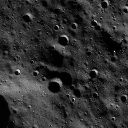

In [4]:
lr_image = Image.open(r"path to image_0.png in low-resolution directory")
lr_image

**OHRC (high-resolution) patch**

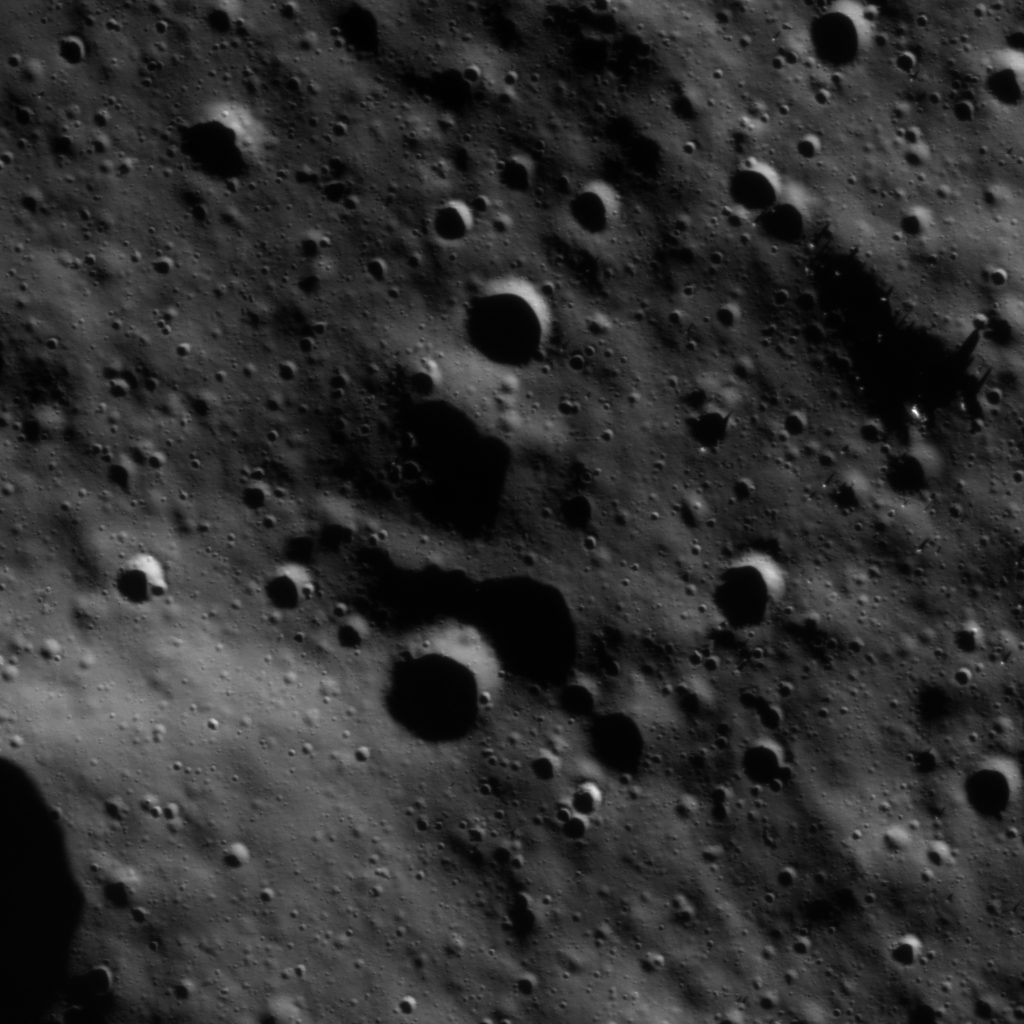

In [5]:
hr_image = Image.open(r"path to image_0.png in low-resolution directory")
hr_image

In [7]:
hr_image_arr = cv2.imread(hr_path+'/image_0.png', cv2.IMREAD_COLOR)
hr_image_arr.shape

(1024, 1024, 3)

In [8]:
lr_image_arr = cv2.imread(lr_path+'/image_0.png', cv2.IMREAD_COLOR)
lr_image_arr.shape

(128, 128, 3)

In [9]:
# grayscale patch of OHRC
hr_gray_arr = cv2.cvtColor(hr_image_arr, cv2.COLOR_BGR2GRAY)

# grayscale patch of TMC2
lr_gray_arr = cv2.cvtColor(lr_image_arr, cv2.COLOR_BGR2GRAY)

## SIFT (Scale-Invariant Feature Transform)

In [117]:
def registration_sift(img1, img2):
    '''
    This function takes two images and register them to a single coordinate system using SIFT as a feature detector
    
    Parameters:
        img1, img2: images
    
    Output:
        registered_img: the registered image
    '''
    
    # sift module
    sift = cv2.SIFT_create()
    
    # keypoints and descriptors
    keypoints_img1, descriptors_img1 = sift.detectAndCompute(img1, None)
    keypoints_img2, descriptors_img2 = sift.detectAndCompute(img2, None)
    
    # keypoints and descriptors matching using BF (Brute-Force) matcher
    matcher = cv2.BFMatcher()
    
    # matches found
    matches = matcher.knnMatch(descriptors_img1, descriptors_img2, k=2)
    
    # filtering good matches using 0.7 as threshold distance values
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    
    # draw the matches between keypoints of both images
    result = cv2.drawMatches(img1, keypoints_img1, img2, keypoints_img2, good_matches, None)
    plt.imshow(result)
    
    # points in source image (img1)
    src_pts = np.float32([keypoints_img1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    # points in destination image (img2)
    dst_pts = np.float32([keypoints_img2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # homograpy matrix finds the transformation between two planes of img1 and img2 using RANSAC (RAndom SAmple Concensus) algorithm
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # image size
    h, w = img1.shape
    
    # wraps an image accroding to the above transformation matrix
    registered_img = cv2.warpPerspective(img2, M, (w, h))
    
    return registered_img

## ORB (Oriented FAST and rotated BRIEF)

In [118]:
def registration_orb(img1, img2):
    '''
    This function takes two images and register them to a single coordinate system using ORB as a feature detector
    
    Parameters:
        img1, img2: images
    
    Output:
        registered_img: the registered image
    '''
    
    # orb module
    orb = cv2.ORB_create()
    
    # keypoints and descriptors
    keypoints_img1, descriptors_img1 = orb.detectAndCompute(img1, None)
    keypoints_img2, descriptors_img2 = orb.detectAndCompute(img2, None)
    
    # keypoints and descriptors matching using BF (Brute-Force) matcher
    matcher = cv2.BFMatcher()
    
    # good matches
    matches = matcher.knnMatch(descriptors_img1, descriptors_img2, k=2)
    
    # filtering good matches using 0.7 as threshold distance values
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    
    # draw the matches between keypoints of both images
    result = cv2.drawMatches(img1, keypoints_img1, img2, keypoints_img2, good_matches, None)
    plt.imshow(result)
    
    # points in source image (img1)
    src_pts = np.float32([keypoints_img1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    # points in destination image (img2)
    dst_pts = np.float32([keypoints_img2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # homograpy matrix finds the transformation between two planes of img1 and img2 using RANSAC (RAndom SAmple Concensus) algorithm
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # image size
    h, w = img1.shape
    
    # wraps an image accroding to the above transformation matrix
    registered_img = cv2.warpPerspective(img2, M, (w, h))
    
    return registered_img

## Evaluation metrics

**PSNR**

In [119]:
def mse(img1, img2):
    '''
    This function calculates the mean squared error between two image
    '''
    err = np.sum((img1.astype("float") - img2.astype("float")) ** 2)
    err /= float(img1.shape[0] * img2.shape[1])
    
    return err

def psnr(original, compared):
    '''
    This function calculates the peak signal-to-noise ratio between two comparable images
    '''
    # Assume the maximum pixel value is 255 for an 8-bit image
    MAX_I = 255.0
    
    # calculate MSE
    mse_value = mse(original, compared)

    # handles the case of MSE being zero (in case of a perfect match)
    if mse_value == 0:
        return float('inf')

    # calculates PSNR
    return 20 * np.log10(MAX_I / np.sqrt(mse_value))

**SSIM**

In [120]:
def ssim(img1, img2):
    '''
    This function calculates the Structural Similarity Index Measure between two images, a similarity evaluation metric.
    '''
    # Based on the SSIM mathematical formula
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


### Baseline: Resize the TMC2 patch to the size of an OHRC patch using interpolation

In [121]:
width, height = hr_gray_arr.shape
dim = (width, height)

Bi-linear interpolation

In [122]:
resized_lr_linear = cv2.resize(lr_gray_arr, dim, interpolation = cv2.INTER_LINEAR)
resized_lr_linear.shape

(1024, 1024)

In [123]:
print(psnr(hr_gray_arr, resized_lr_linear))

29.157586976887927


In [124]:
print(ssim(hr_gray_arr, resized_lr_linear))

0.7697867544141787


Bicubic interpolation

In [125]:
resized_lr_cubic = cv2.resize(lr_gray_arr, dim, interpolation = cv2.INTER_CUBIC)
resized_lr_cubic.shape

(1024, 1024)

In [126]:
print(psnr(hr_gray_arr, resized_lr_cubic))

28.849311928126063


In [127]:
print(ssim(hr_gray_arr, resized_lr_cubic))

0.7593861415263033


## Results with SIFT

Result using bi-linear interpolation

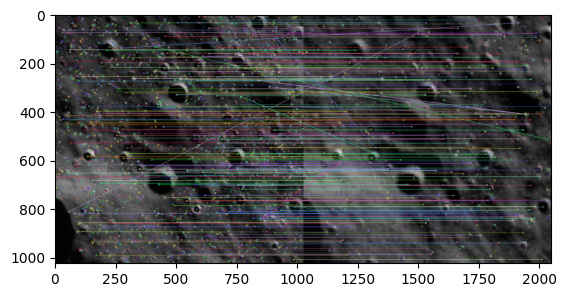

In [128]:
result_linear_sift = registration_sift(hr_gray_arr, resized_lr_linear)

In [129]:
print(ssim(hr_gray_arr, result_linear_sift))

0.7694955990421493


In [130]:
print(psnr(hr_gray_arr, result_linear_sift))

29.13491224030736


Results using bi-cubic interpolation

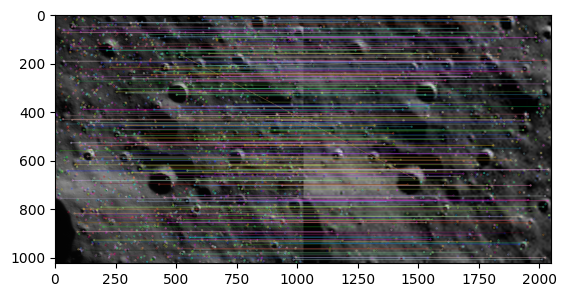

In [131]:
result_cubic_sift = registration_sift(hr_gray_arr, resized_lr_cubic)

In [132]:
print(ssim(hr_gray_arr, result_cubic_sift))

0.7585057469144657


In [133]:
print(psnr(hr_gray_arr, result_linear_sift))

29.13491224030736


### Results with ORB

Results with bi-linear interpolation

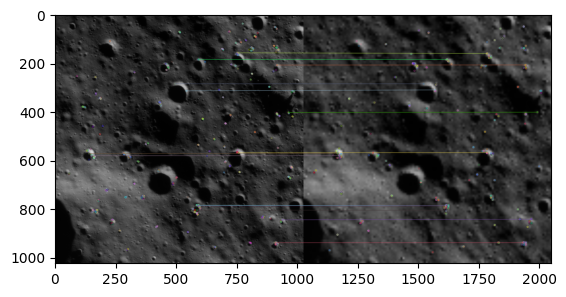

In [134]:
result_linear_orb = registration_orb(hr_gray_arr, resized_lr_linear)

In [135]:
print(ssim(hr_gray_arr, result_linear_orb))

0.7554081359955196


In [136]:
print(psnr(hr_gray_arr, result_linear_orb))

28.4048524766987


Results with bi-cubic interpolation

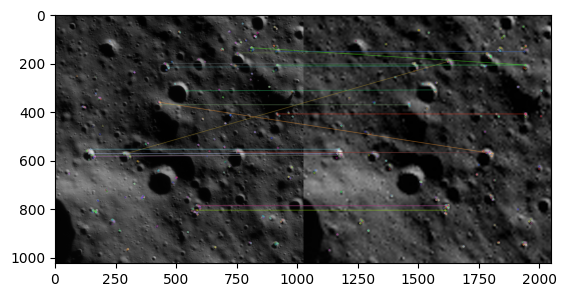

In [137]:
result_cubic_orb = registration_orb(hr_gray_arr, resized_lr_cubic)

In [138]:
print(ssim(hr_gray_arr, result_cubic_orb))

0.7475760793968816


In [139]:
print(psnr(hr_gray_arr, result_cubic_orb))

28.267952607254074


### Results with IntFeat

In [143]:
def IntFeat(img1, img2):
    sift = cv2.SIFT_create()

    keypoints_img1_sift, descriptors_img1_sift = sift.detectAndCompute(img1, None)
    keypoints_img2_sift, descriptors_img2_sift = sift.detectAndCompute(img2, None)


    orb = cv2.ORB_create()
    keypoints_img1_orb, descriptors_img1_orb = orb.detectAndCompute(img1, None)
    keypoints_img2_orb, descriptors_img2_orb = orb.detectAndCompute(img2, None)

    #IntFeat


    def resize_and_combine_descriptors(descriptors_sift, descriptors_orb):
        # Convert ORB descriptors to float
        descriptors_orb = descriptors_orb.astype('float32')

        # Reduce dimensionality of SIFT descriptors to match ORB
        pca = PCA(n_components=descriptors_orb.shape[1])
        descriptors_sift_reduced = pca.fit_transform(descriptors_sift)

        # Combine descriptors
        combined_descriptors = np.vstack((descriptors_sift_reduced, descriptors_orb))
        return combined_descriptors

    keypoints_img1 = keypoints_img1_sift + keypoints_img1_orb
    keypoints_img2 = keypoints_img2_sift + keypoints_img2_orb

    descriptors_img1 = resize_and_combine_descriptors(descriptors_img1_sift, descriptors_img1_orb)
    descriptors_img2 = resize_and_combine_descriptors(descriptors_img2_sift, descriptors_img2_orb)

    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptors_img1, descriptors_img2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    result = cv2.drawMatches(img1, keypoints_img1, img2, keypoints_img2, good_matches, None)

    plt.imshow(result)
    src_pts = np.float32([keypoints_img1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints_img2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h, w = img1.shape
    result_intfeat = cv2.warpPerspective(img2, M, (w, h))
    
    return result_intfeat   

Results with bi-linear interpolation

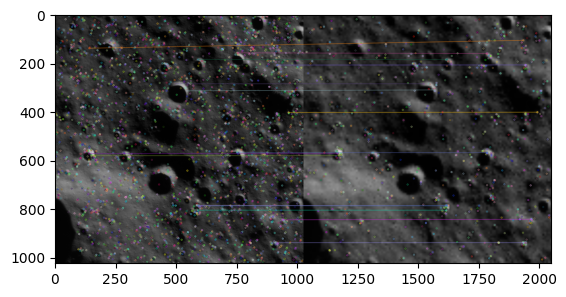

In [145]:
result_linear_intfeat = IntFeat(hr_gray_arr, resized_lr_linear)

In [146]:
print(ssim(hr_gray_arr, result_linear_intfeat))

0.7633455550241809


In [147]:
print(psnr(hr_gray_arr, result_linear_intfeat))

28.77412779140808


Results with bi-cubic interpolation

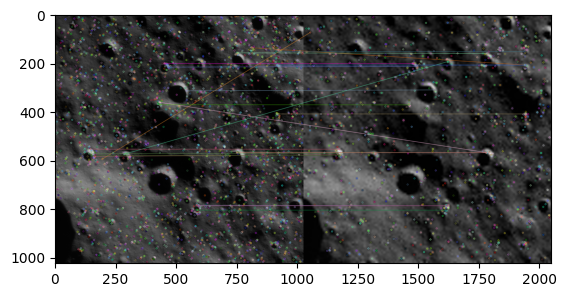

In [151]:
result_cubic_intfeat = IntFeat(hr_gray_arr, resized_lr_cubic)

In [152]:
print(ssim(hr_gray_arr, result_cubic_intfeat))

0.7380302126070731


In [153]:
print(psnr(hr_gray_arr, result_cubic_intfeat))

27.781467025981186
